In [3]:
!pip install kaggle
! mkdir ~/.kaggle
! cp /content/kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


## Artworks by diff artists

https://www.kaggle.com/ikarus777/best-artworks-of-all-time

In [4]:
!kaggle datasets download -d ikarus777/best-artworks-of-all-time
!unzip -q /content/best-artworks-of-all-time.zip

#DATA_PATH = '/content/resized/resized'
DATA_PATH = '/content/images/images/Alfred_Sisley'

100% 2.28G/2.29G [01:05<00:00, 20.9MB/s]
100% 2.29G/2.29G [01:05<00:00, 37.5MB/s]


## Van goh paintings

https://www.kaggle.com/ipythonx/van-gogh-paintings?select=Drawings

divided into diff sections.

Largest sections is drawing section, with 1002 images

In [143]:
!kaggle datasets download -d ipythonx/van-gogh-paintings
!unzip -q /content/van-gogh-paintings.zip

 99% 481M/485M [00:24<00:00, 20.8MB/s]
100% 485M/485M [00:24<00:00, 21.0MB/s]


In [ ]:
DATA_PATH = '/content/Drawings'

## Faces dataset

50000 face images of 500*500
https://www.kaggle.com/arnaud58/flickrfaceshq-dataset-ffhq?select=00028.png



In [ ]:
!kaggle datasets download -d arnaud58/flickrfaceshq-dataset-ffhq

## Chinese fineart dataset 
https://www.kaggle.com/rickyjli/chinese-fine-art

In [ ]:
!kaggle datasets download -d rickyjli/chinese-fine-art

## impressionist-classifier-data

https://www.kaggle.com/delayedkarma/impressionist-classifier-data?


In [ ]:
!kaggle datasets download -d delayedkarma/impressionist-classifier-data

## Paired landscape and Monet-Stylized image

https://www.kaggle.com/shcsteven/paired-landscape-and-monetstylised-image?

In [158]:
!kaggle datasets download -d shcsteven/paired-landscape-and-monetstylised-image
!unzip -q '/content/paired-landscape-and-monetstylised-image.zip'

 67% 2.23G/3.33G [01:16<00:37, 31.4MB/s]
User cancelled operation
[/content/paired-landscape-and-monetstylised-image.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/paired-landscape-and-monetstylised-image.zip or
        /content/paired-landscape-and-monetstylised-image.zip.zip, and cannot find /content/paired-landscape-and-monetstylised-image.zip.ZIP, period.


In [6]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [7]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [113]:
import glob

**buffer_size** (argument to tf.data.Dataset.shuffle()) -  affects the randomness of the transformation. We designed the Dataset.shuffle() transformation (like the tf.train.shuffle_batch() function that it replaces) to handle datasets that are too large to fit in memory. Instead of shuffling the entire dataset, it maintains a buffer of buffer_size elements, and randomly selects the next element from that buffer (replacing it with the next input element, if one is available). 

Changing the value of buffer_size affects how uniform the shuffling is: 

1.   if buffer_size is greater than the number of elements in the dataset, you get a uniform shuffle 
2.   if it is 1 then you get no shuffling at all. 

For very large datasets, a typical "good enough" approach is to randomly shard the data into multiple files once before training, then shuffle the filenames uniformly, and then use a smaller shuffle buffer. However, the appropriate choice will depend on the exact nature of your training job.

(source -  Stackoverflow - https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle)

#### Test   area

In [ ]:
SEED_SIZE = GENERATE_SQUARE*2
SEED_SIZE = 50

generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
SEED_SIZE = GENERATE_SQUARE*2

generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
SEED_SIZE = 10000
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [117]:
NUmpy_file = glob.glob(DATA_PATH + '/*.npy')
NUmpy_file

['/content/images/images/Alfred_Sisley/training_data_192_192.npy']

In [119]:
!mv NUmpy_file /content/
print(glob.glob(DATA_PATH + '/*.npy'))

mv: cannot stat 'NUmpy_file': No such file or directory
['/content/images/images/Alfred_Sisley/training_data_192_192.npy']


In [ ]:
#

# Start GAN

In [145]:
# Generation resolution - Must be squareTraining data is also scaled to this
# Note GENERATE_RES 4 or higher will blow Google CoLab's memory and have not been tested extensivly.
GENERATE_RES = 6                    # Generation resolution factor   # (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3


# Preview image that will be saved
PREVIEW_ROWS = 10
PREVIEW_COLS = 10
PREVIEW_MARGIN = 16

SEED_SIZE = 50   #GENERATE_SQUARE*2    # Size vector to generate images from

# Configuration
#DATA_PATH = '/content/resized/resized'
#DATA_PATH = '/content/images/images/Alfred_Sisley'
DATA_PATH = '/content/Drawings'


output_path = '/content/drive/My Drive/projects/output'
Model_save_PATH  = '/content/drive/My Drive/projects'

EPOCHS = 200
BATCH_SIZE = 32
#BUFFER_SIZE = 60000
BUFFER_SIZE = 50


print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 192px square images.


In [146]:
# Image set has 11,682 images.  Can take over an hour for initial preprocessing.
# Because of this time needed, save a Numpy preprocessed file.

# Note, that file is large enough to cause problems for sume verisons of Pickle,so Numpy binary files are used.


training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH)
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      #img = Image.open(img_name).convert('RGB')
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS).convert('RGB')   #to convert all files to RGB

      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = (training_data / 127.5) - 1.    #this is to normalize the data 
                               # value choosen is 127.5 since this is a float 32 type integer.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

  0%|          | 3/1002 [00:00<00:42, 23.52it/s]

Looking for file: /content/Drawings/training_data_192_192.npy
Loading training images...


100%|██████████| 1002/1002 [00:39<00:00, 25.60it/s]


Saving training image binary...
Image preprocess time: 0:00:40.89


In [111]:
!mv '/content/images/images/Alfred_Sisley/training_data_128_128.npy' '/content/drive/My Drive/projects/output/alfred_sisley_96_96.npy'

In [ ]:
#!cp  '/content/drive/My Drive/projects/output/training_data_96_96.npy'  '/content/drive/My Drive/projects/output/All_artist_data_96_96.npy'

In [147]:
faces_path = os.path.join(DATA_PATH)

for filename in tqdm(os.listdir(faces_path)):
    if 'jpg' in filename:
      b += 1
    else:
      c += 1

print(b , c)

100%|██████████| 1003/1003 [00:00<00:00, 549560.67it/s]

28346 8


In [148]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [149]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    print(model.summary())
    return model

def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    print(model.summary())

    return model

In [150]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1
   
  #output_path = '/content/drive/My Drive/projects/output'
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 4096)              208896    
_________________________________________________________________
reshape_15 (Reshape)         (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d_60 (UpSampling (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 8, 8, 256)         590080    
_________________________________________________________________
batch_normalization_88 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_75 (Activation)   (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_61 (UpSampling (None, 16, 16, 256)     

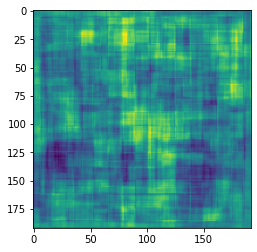

In [151]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [152]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.49896917]], shape=(1, 1), dtype=float32)


In [153]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [154]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

In [155]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [156]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')


In [157]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=0.6852952837944031,disc loss=1.388561487197876, {hms_string(epoch_elapsed)}
Epoch 2, gen loss=0.6931474804878235,disc loss=1.3862941265106201, {hms_string(epoch_elapsed)}
Epoch 3, gen loss=0.6931474804878235,disc loss=1.3862941265106201, {hms_string(epoch_elapsed)}
Epoch 4, gen loss=0.6931474804878235,disc loss=1.3862941265106201, {hms_string(epoch_elapsed)}
Epoch 5, gen loss=0.6931474804878235,disc loss=1.386293888092041, {hms_string(epoch_elapsed)}
Epoch 6, gen loss=0.6931474804878235,disc loss=1.386293888092041, {hms_string(epoch_elapsed)}
Epoch 7, gen loss=0.6931474804878235,disc loss=1.3862937688827515, {hms_string(epoch_elapsed)}
Epoch 8, gen loss=0.6931474804878235,disc loss=1.3862935304641724, {hms_string(epoch_elapsed)}
Epoch 9, gen loss=0.6931473612785339,disc loss=1.3862926959991455, {hms_string(epoch_elapsed)}
Epoch 10, gen loss=0.6931469440460205,disc loss=1.386285662651062, {hms_string(epoch_elapsed)}
Epoch 11, gen loss=0.3726029396057129,disc loss=1.587

In [75]:
generator.save(os.path.join(Model_save_PATH ,"face_generator5by7.h5"))